In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import calendar
import itertools

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def output_to_accu(model, X, y):
    nb_errors = 0
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        _, predicted_classes = output.max(1)
        for k in range(1):
            if y[b + k, predicted_classes[k]] != 1.:
                nb_errors = nb_errors + 1
    accuracy = 100 * (1 - nb_errors / X.size(0))
    return accuracy

In [4]:
def output_to_loss(model, X, y):
    nb_errors = 0
    loss = 0
    criterion = nn.BCELoss()
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        loss += criterion(output, y.narrow(0, b, 1))
        
    return loss

In [6]:
indices_price_excel = pd.read_csv('SW_data/prices.csv', index_col=0, parse_dates=True).asfreq('D', method='ffill')

In [7]:
bench_price = indices_price_excel['SPI Index'].asfreq('D', method='ffill')
price = indices_price_excel[indices_price_excel.columns[1:]].asfreq('D', method='ffill')
daily_returns = price.pct_change().dropna()
daily_return_bench = bench_price.pct_change()
price.head()

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1996-01-04,426.47,2049.35,423.28,3395.8
1996-01-05,426.04,2054.88,424.38,3376.1
1996-01-06,426.04,2054.88,424.38,3376.1
1996-01-07,426.04,2054.88,424.38,3376.1
1996-01-08,427.94,2071.98,427.67,3368.1


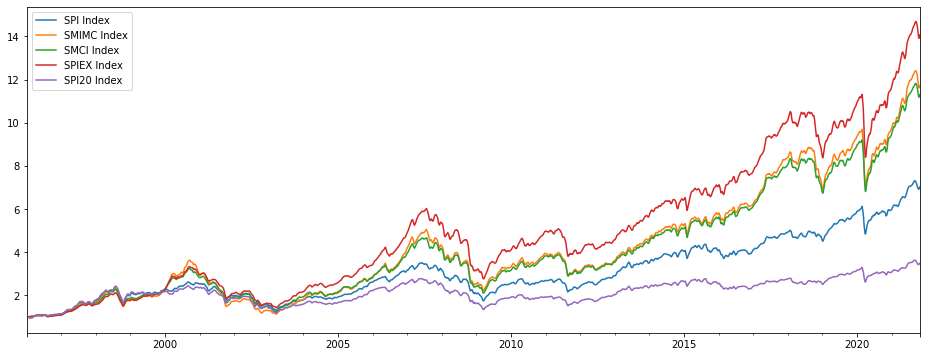

In [8]:
fig, ax = plt.subplots(figsize=(16,6))
(indices_price_excel.pct_change() + 1).cumprod().rolling(20).mean().plot(ax=ax)
plt.show()

In [9]:
mom12 = price.pct_change(periods=21 * 12)
mom6 = price.pct_change(periods=21 * 6)
mom1 = price.pct_change(periods=21 * 1)

ma200 = np.log(price / price.rolling(window=200).mean())
ma100 = np.log(price / price.rolling(window=100).mean())
ma50 = np.log(price / price.rolling(window=50).mean())

vol12 = price.rolling(window=21 * 12).std()
vol6 = price.rolling(window=21 * 6).std()
vol1 = price.rolling(window=21 * 1).std()

In [10]:
ema_12 = price.ewm(span=10).mean()
ema_26 = price.ewm(span=60).mean()
MACD = ema_12 - ema_26

In [11]:
def RSI(price, window):
    price_diff = price.diff()
    gain = price_diff.mask(price_diff < 0, 0.0)
    loss = - price_diff.mask(price_diff > 0, -0.0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [12]:
RSI14 = RSI(price, 14)
RSI9 = RSI(price, 9)
RSI3 = RSI(price, 3)

In [13]:
df_dict = {}
df_X = pd.DataFrame()
for col in price.columns:
    df_temp = pd.concat([ma50[col], ma100[col], ma200[col],
                         mom12[col], mom6[col], mom1[col],
                         vol12[col], vol6[col], vol1[col],
                         RSI14[col], RSI9[col], RSI3[col], 
                         MACD[col]], axis=1).asfreq('D', method='ffill').loc['1997-01-01':].fillna(method='ffill')
    df_temp.columns = ['ma50', 'ma100', 'ma200', 'mom12', 'mom6', 'mom1', 
                       'vol12', 'vol6', 'vol1', 'RSI14', 'RSI9', 'RSI3', 'MACD']
    df_dict[col] = df_temp
    
df_X = pd.concat(df_dict, axis=1)

In [14]:
df_X.head()

SMIMC Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01    0.014890  0.028585  0.045367  0.010506  0.075344  0.019856   
1997-01-02    0.014115  0.027852  0.045311  0.011880  0.083172  0.006702   
1997-01-03    0.024387  0.038145  0.056274  0.017091  0.085253  0.024929   
1997-01-04    0.023670  0.037469  0.056143  0.017091  0.085253  0.024929   
1997-01-05    0.022953  0.036752  0.056000  0.017091  0.085253  0.024929   

                                                      ... SPI20 Index  \
                vol12       vol6      vol1     RSI14  ...       mom12   
1997-01-01  13.719565  10.620504  2.162347  0.615010  ...    0.074637   
1997-01-02  13.744065  10.594086  2.318069  0.832454  ...    0.074725   
1997-01-03  13.788874  10.691504  2.958671  0.898156  ...    0.066044   
1997-01-04  13.833463  10.779621  3.388369  0.898156  ...    0.066044   
1997-01-05  13.877834  10.858662  3.681764  0.898156  ...    0.066044   

                                                                            \
                mom6      mom1       vol12       vol6       vol1     RSI14   
1997-01-01  0.067595  0.021931  115.067084  87.412133  34.653116  0.781818   
1997-01-02  0.070494  0.021295  115.920325  87.797945  36.174019  0.768827   
1997-01-03  0.080575  0.026255  116.773840  87.660734  35.802564  0.733645   
1997-01-04  0.080575  0.026255  117.613151  87.460668  34.737640  0.733645   
1997-01-05  0.080575  0.026255  118.438562  87.197313  32.911998  0.733645   

                                           
                RSI9      RSI3       MACD  
1997-01-01  0.869324  0.810559  54.704790  
1997-01-02  0.927896  0.000000  56.635096  
1997-01-03  0.905421  0.000000  57.512073  
1997-01-04  0.905421  0.000000  57.863229  
1997-01-05  0.760933  0.000000  57.796180  

[5 rows x 52 columns]

In [15]:
monthly_return = price.pct_change().resample('M').agg(lambda x: (x + 1).prod() - 1)
best_pred = monthly_return.rank(axis=1).replace({1: 0., 2: 0., 3: 1., 4: 1.}).shift(-1).loc['1997-01-31':]
best_pred_one = monthly_return.rank(axis=1).replace({1: 0., 2: 0., 3: 0., 4: 1.}).shift(-1).loc['1997-01-31':]
best_pred_one.head()

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1997-01-31,1.0,0.0,0.0,0.0
1997-02-28,0.0,0.0,0.0,1.0
1997-03-31,0.0,0.0,0.0,1.0
1997-04-30,1.0,0.0,0.0,0.0
1997-05-31,0.0,0.0,0.0,1.0


In [16]:
def pred_to_perf(df_pred, tax=0., log=False):
    first_date = df_pred.index[0]
    last_date = df_pred.index[-1]
    daily_ret = daily_returns[first_date:last_date].asfreq('D', method='ffill')
    df_pred_daily = df_pred.reindex(daily_ret.index, method='ffill').shift(1)
    df_perf = (df_pred_daily * daily_ret).sum(axis=1)
    df_cost = (df_pred_daily.diff().fillna(0) != 0).any(axis=1).astype(int) * tax
    if log is False:
        perf = (1 + df_perf - df_cost).cumprod()
    else:
        perf = np.log(1 + df_perf - df_cost).cumsum()
    return perf

In [17]:
def pred_to_daily_ret(df_pred, tax=0., log=False):
    first_date = df_pred.index[0]
    last_date = df_pred.index[-1]
    daily_ret = daily_returns[first_date:last_date].asfreq('D', method='ffill')
    df_pred_daily = df_pred.reindex(daily_ret.index, method='ffill').shift(1)
    df_daily_ret = (df_pred_daily * daily_ret).sum(axis=1)
    return df_daily_ret

In [18]:
def price_to_perf(df, log=False):
    df = df.asfreq('D', method='ffill')
    if log is False:
        perf = (1 + df.pct_change().fillna(0)).cumprod()
    else:
        perf = np.log(1 + df.pct_change().fillna(0)).cumsum()
    return perf

In [41]:
class MLP(nn.Module):
    def __init__(self, x1, x2, x3, pdrop=0.1):
        super().__init__()
        self.fc1 = nn.Linear(x1 * x2 * x3, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 4)
        self.drop = nn.Dropout(pdrop)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu(self.drop(self.fc1(x)))
        x = self.relu(self.drop(self.fc2(x)))
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x

In [20]:
class ConvNet(nn.Module):
    def __init__(self, dim1, dim2, dim3, dim1_kernel1=2, dim2_kernel1=2, dim1_kernel2=2, dim2_kernel2=2, pdrop=0.01):
        super().__init__()
        
        self.dim1 = dim1
        self.dim2 = dim2
        self.dim3 = dim3
        
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(dim1_kernel1, dim2_kernel1, dim3))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(dim1_kernel2, dim2_kernel2, 1))
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(32 * (dim1 - dim1_kernel1 - dim1_kernel2 + 2) * (dim2 - dim2_kernel1 - dim2_kernel2 + 2), 64)
        self.fc2 = nn.Linear(64, 4)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(pdrop)
        self.drop2d = nn.Dropout2d(pdrop)

    def forward(self, x):
        
        x = x.view(x.size(0), 1, x.size(1), x.size(2), x.size(3))
    
        x = self.relu(self.drop2d(self.conv1(x)))
        x = self.relu(self.drop2d(self.conv2(x)))
        
        #print(x.shape)
        x = x.flatten(start_dim=1)

        x = self.relu(self.drop(self.fc1(x)))
        # x = self.relu(self.drop(self.fc2(x)))
        x = self.sigmoid(self.fc2(x))

        return x

In [21]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_size=5, num_layers=2, dropout=0):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size)
        x = x.view(x.size(0), x.size(1), x.size(2) * x.size(3))
        x, _ = self.lstm(x, (h0, c0))
        x = self.relu(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))
        
        return x

In [81]:
def strategie(df_input_all, best_pred, model_name='MLP', nb_epochs=50, input_period=8, month_test_period=5, training_window=5, mini_batch_size=1, verbose=0):
    
    first_end_date = '2002-02-01'
    num_tickers = 4
    num_features = 13
    
    # ML parameters
    pdrop=0.1
    eta = 1e-3
    
    # LSTM parameters
    hidden_size = 20
    num_layers = 5
    
    prob_output = []
    pred_output = []
    all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
    for i, end_date in enumerate(tqdm(all_end_dates)):
        # Data
        start_date = end_date - relativedelta(years=training_window)
        #start_date_input = start_date.replace(day=1) 
        start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
        df_input = df_input_all.loc[start_date_input:end_date]
        df_output = best_pred.loc[start_date:end_date] # best_pred // best_pred_one

        X = []
        for idx in df_output.index:
            df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
            X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
            X.append(X_period)
        X = np.array(X)
        y = df_output.values

        if i == 0:
            #first_start_date_test = end_date.replace(day=31, month=1)
            first_start_date_test = end_date - relativedelta(months=5)

        # start_date_test = end_date.replace(day=31, month=1)
        start_date_test = (end_date - relativedelta(months=month_test_period))
        year_test, month_test = start_date_test.year, start_date_test.month
        start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
        split_index = df_output.index.get_loc(start_date_test)    
        X_train, y_train = X[:split_index], y[:split_index]
        X_test, y_test = X[split_index:], y[split_index:]

        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

        train_mean = X_train.mean(dim=[0,1,2], keepdim=True)
        train_std = X_train.std(dim=[0,1,2], keepdim=True)
        X_train = X_train.sub_(train_mean).div_(train_std)

        #train_size = X_train.size(0)
        #shuffle_idx = torch.randperm(train_size)
        #X_train = X_train[shuffle_idx, :, :]
        #y_train = y_train[shuffle_idx, :]

        test_mean = X_test.mean(dim=[0,1,2], keepdim=True)
        test_std = X_test.std(dim=[0,1,2], keepdim=True)
        X_test = X_test.sub_(test_mean).div_(test_std)

        # Model
        dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
        if model_name == 'MLP':
            model = MLP(dim1, dim2, dim3, pdrop=pdrop)
        elif model_name == 'CONVNET':
            model = ConvNet(dim1, dim2, dim3, pdrop=pdrop)
        elif model_name == 'LSTM':
            model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, hidden_size=hidden_size, num_layers=num_layers)
            
        optimizer = torch.optim.Adam(model.parameters(), lr=eta)
        #optimizer = torch.optim.RMSprop(model.parameters(), lr=eta)
        criterion = nn.BCELoss()
        #criterion = nn.MSELoss()

        train_accu_list = []
        train_loss_list = []
        test_accu_list = []
        test_loss_list = []
        for e in range(nb_epochs):
            acc_loss = 0
            model.train()
            for b in range(0, X_train.size(0), mini_batch_size):
                optimizer.zero_grad()
                output = model(X_train.narrow(0, b, mini_batch_size))
                loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
                acc_loss = acc_loss + loss.item()
                loss.backward()
                optimizer.step()
            
            model.eval()
            train_accu = output_to_accu(model, X_train, y_train)
            train_accu_list.append(train_accu)
            test_accu = output_to_accu(model, X_test, y_test)
            test_accu_list.append(test_accu)

            train_loss = output_to_loss(model, X_train, y_train).detach().numpy()
            train_loss_list.append(train_loss)
            test_loss = output_to_loss(model, X_test, y_test).detach().numpy()
            test_loss_list.append(test_loss)

            if verbose == 1:
                if (e % 5) == 0:
                    print('epoch', e + 1, ':', acc_loss)
        
        if verbose == 1:
            fig = plt.figure(figsize=(12,6))
            plt.plot(list(range(nb_epochs)), train_loss_list, label='Train loss')
            plt.plot(list(range(nb_epochs)), test_loss_list, label='Test loss')
            plt.legend()
            plt.show()
            fig = plt.figure(figsize=(12,6))
            plt.plot(list(range(nb_epochs)), train_accu_list, label='Train accuracy')
            plt.plot(list(range(nb_epochs)), test_accu_list, label='Test accuracy')
            plt.legend()
            plt.show()

        model.eval()
        pred = np.zeros((X_test.size(0), y_test.size(1)))
        output_list = []
        for b in range(0, X_test.size(0)):
            output = model(X_test.narrow(0, b, 1))
            _, pred_index = output.max(1)
            pred[b, pred_index.item()] = 1
            output_list.append(output.detach().numpy())
        prob_output.append(np.array(output_list))
        pred_output.append(pred)

    pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
    prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)
    return df_pred, df_prob

In [92]:
models_list = ['MLP', 'CONVNET', 'LSTM']
#models_list = ['MLP']
df_pred_dict = {}
df_prob_dict = {}
perf_pred_dict_gross = {}
perf_pred_dict_net = {}
nb_epochs = 1
input_period = 8
mini_batch_size = 1
verbose = 0
training_window = 5

for i, model_name in enumerate(models_list):
    df_pred_dict[model_name], df_prob_dict[model_name] = strategie(df_input_all=df_X, best_pred=best_pred_one, model_name=model_name, nb_epochs=nb_epochs, input_period=input_period, mini_batch_size=mini_batch_size, verbose=verbose, training_window=training_window)
    perf_pred_dict_gross[model_name] = pred_to_perf(df_pred_dict[model_name])
    perf_pred_dict_net[model_name] = pred_to_perf(df_pred_dict[model_name], 0.0012)
    if i == 0:
        df_prob_ensemble = df_prob_dict[model_name].copy()
    else:
        df_prob_ensemble += df_prob_dict[model_name]

df_prob_ensemble /= 3
df_pred_dict['Ensemble'] = df_prob_ensemble.rank(axis=1).replace({1: 0., 2: 0., 3: 1., 4: 1.})

100%|██████████| 40/40 [00:25<00:00,  1.59it/s]


In [100]:
perf_bench = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=False)
perf_bench_log = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=True)

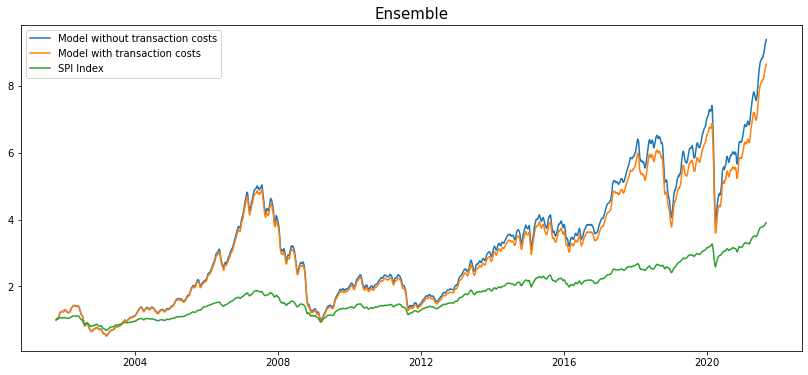

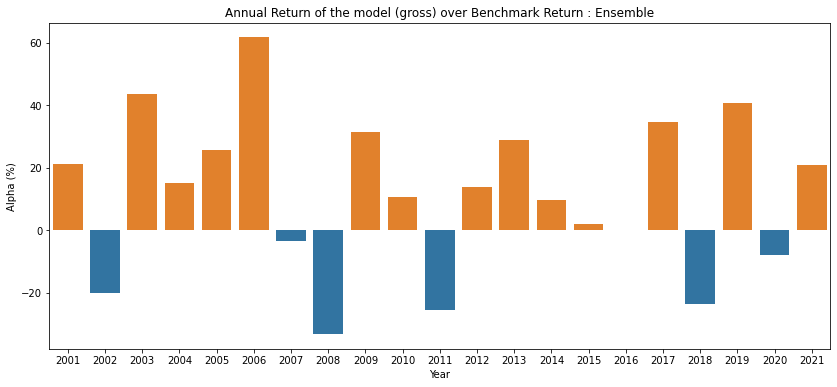

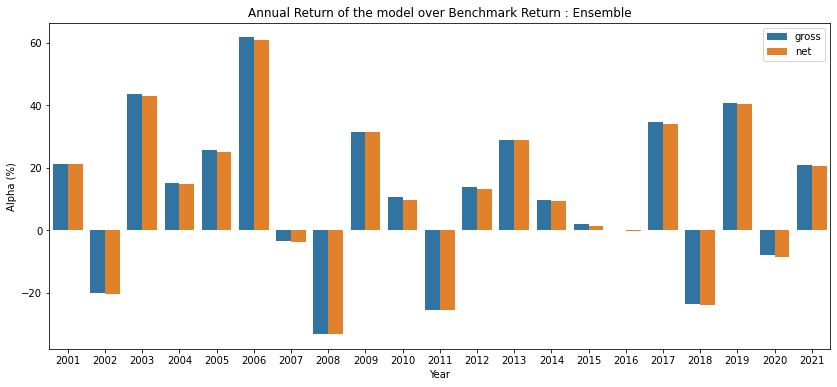

In [89]:
model = 'Ensemble'
performance_plot(df_pred_dict[model], model)
annual_alpha_plot(perf_bench, df_pred_dict[model], model)
annual_alpha_plot_grossnet(perf_bench, df_pred_dict[model], model)

for model in df_pred_dict.keys():
    performance_plot(df_pred_dict[model], model)
    annual_alpha_plot(perf_bench, df_pred_dict[model], model)
    annual_alpha_plot_grossnet(perf_bench, df_pred_dict[model], model)

In [113]:
bench_stats = perf_to_stat(perf_bench, perf_bench)
stats = []
stats.append(bench_stats + [0])
for model in df_pred_dict.keys():
    
    perf_gross = pred_to_perf(df_pred_dict[model], 0., log=False)
    perf_net = pred_to_perf(df_pred_dict[model], 0.0012, log=False)
    
    turnover_num = turnover(df_pred_dict[model])
    stats.append(perf_to_stat(perf_gross, perf_net) + [turnover(df_pred_dict[model])])
stats = np.array(stats)

df_stats = pd.DataFrame(data=stats, columns=['Gross avg. annual return (%)','Net avg. annual return (%)', 'Avg. annual vol. (%)', 'Avg Sharpe ratio', 'Max. Drawdown (%)', 'Turnover'], index=['Benchmark SPI'] + list(df_pred_dict.keys())).round(2)
df_stats.Turnover = df_stats.Turnover.apply(int)
df_stats

,Gross avg. annual return (%),Net avg. annual return (%),Avg. annual vol. (%),Avg Sharpe ratio,Max. Drawdown (%),Turnover
Benchmark SPI,8.23,8.23,14.47,0.57,40.91,0
MLP,8.77,8.32,14.55,0.57,43.36,79
CONVNET,7.65,7.57,15.29,0.50,42.31,11
LSTM,10.11,9.93,13.77,0.72,41.29,29
Ensemble,19.83,19.51,27.38,0.71,71.97,51


In [70]:
df = pd.DataFrame(index=models_list, columns=models_list)
for comb in itertools.product(models_list, repeat=2):
    model1 = comb[0]
    model2 = comb[1]
    df.loc[model1][model2] = correlation(df_pred_dict[model1], df_pred_dict[model2])
df.round(2)

,MLP,CONVNET,LSTM
MLP,1.0,0.65,0.504167
CONVNET,0.65,1.0,0.4375
LSTM,0.504167,0.4375,1.0


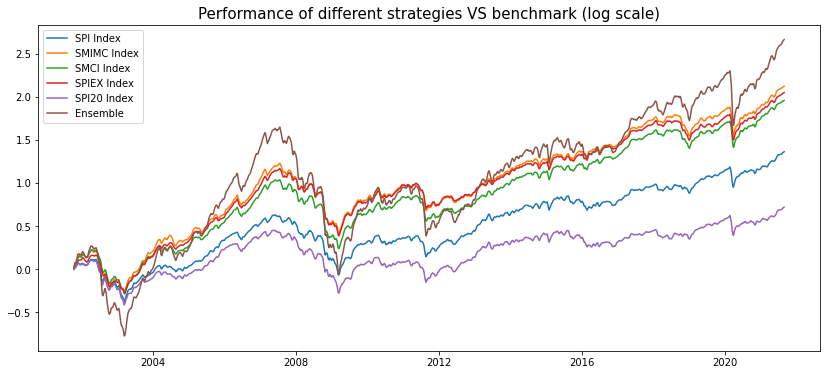

In [74]:
perf_bench_log = price_to_perf(indices_price_excel.loc[df_pred_dict['MLP'].index[0]:df_pred_dict['MLP'].index[-1]], log=True)
data = pd.DataFrame(perf_bench_log)

data = pd.concat([data, pred_to_perf(df_pred_dict['Ensemble'], 0., log=True).rename(model)], axis=1)

fig = plt.figure(figsize=(14,6))
plt.title('Performance of different strategies VS benchmark (log scale)', fontsize=15)
sns.lineplot(data=data.rolling(20).mean(), dashes=False)
plt.show()

In [55]:
def perf_to_stat(perf_gross, perf_net):
    
    #perf_gross = pred_to_perf(df_pred, 0.)
    #perf_net = pred_to_perf(df_pred, 0.0012)
    
    year_group_gross = perf_gross.resample('Y')
    year_group_net = perf_net.resample('Y')

    average_year_return_gross = ((year_group_gross.last() - year_group_gross.first()) / year_group_gross.first()).mean() * 100
    average_year_return_net = ((year_group_net.last() - year_group_net.first()) / year_group_net.first()).mean() * 100

    average_year_std = perf_gross.pct_change().std() * np.sqrt(256) * 100
    average_year_sharpe = average_year_return_net / average_year_std
    
    dd_window = 252
    roll_max = perf_gross.rolling(dd_window).max()
    daily_dd = perf_gross / roll_max - 1
    max_daily_dd = np.abs(daily_dd.rolling(dd_window, min_periods=1).min()).max() * 100

    return [average_year_return_gross, average_year_return_net, average_year_std, average_year_sharpe, max_daily_dd]

In [56]:
def performance_plot(df_pred, model):
    perf_pred_gross = pred_to_perf(df_pred, 0.).rename('Model without transaction costs')
    perf_pred_net = pred_to_perf(df_pred, 0.0012).rename('Model with transaction costs')

    data = pd.concat([perf_pred_gross, perf_pred_net, price_to_perf(bench_price[df_pred.index[0]:df_pred.index[-1]])], axis=1)

    fig = plt.figure(figsize=(14,6))
    plt.title(model, fontsize=15)
    sns.lineplot(data=data.rolling(20).mean(), dashes=False)
    plt.show()

In [112]:
def turnover(df_pred):
    return (df_pred.diff().fillna(0) != 0).any(axis=1).astype(int).sum()

In [66]:
def annual_alpha_plot_grossnet(perf_bench, df_pred, model):
    perf_pred_gross = pred_to_perf(df_pred, 0.).rename('Model without transaction costs')
    perf_pred_net = pred_to_perf(df_pred, 0.0012).rename('Model with transaction costs')

    year_group_bench = perf_bench.resample('Y')
    year_group_pred_gross = perf_pred_gross.resample('Y')
    year_group_pred_net = perf_pred_net.resample('Y')

    annual_returns_bench = (year_group_bench.last() - year_group_bench.first()) / year_group_bench.first()
    annual_returns_pred_gross = (year_group_pred_gross.last() - year_group_pred_gross.first()) / year_group_pred_gross.first()
    annual_returns_pred_net = (year_group_pred_net.last() - year_group_pred_net.first()) / year_group_pred_net.first()


    annual_diff_gross = (annual_returns_pred_gross - annual_returns_bench) * 100
    annual_diff_net = (annual_returns_pred_net - annual_returns_bench) * 100

    df_annual_diff = pd.DataFrame(columns=['year', 'gross', 'net'])
    df_annual_diff['year'] = annual_diff_net.index.year
    df_annual_diff['year'] = df_annual_diff.year.apply(str)
    df_annual_diff['gross'] = annual_diff_gross.values
    df_annual_diff['net'] = annual_diff_net.values
    df_annual_diff = df_annual_diff.melt(id_vars=['year'], var_name='gross_net', value_name='alpha')
    df_annual_diff['sign'] = np.sign(df_annual_diff.alpha)

    fig, ax = plt.subplots(figsize=(14,6))
    sns.barplot(data=df_annual_diff, x='year', y='alpha', hue='gross_net', dodge=True)
    #ax.get_legend().remove()
    ax.get_legend().set_title(None)
    plt.ylabel('Alpha (%)')
    plt.xlabel('Year')
    plt.title('Annual Return of the model over Benchmark Return : ' + model)
    plt.show()

In [67]:
def annual_alpha_plot(perf_bench, df_pred, model):
    
    perf_pred_gross = pred_to_perf(df_pred, 0.).rename('Model without transaction costs')
    perf_pred_net = pred_to_perf(df_pred, 0.0012).rename('Model with transaction costs')
    
    year_group_bench = perf_bench.resample('Y')
    year_group_pred_gross = perf_pred_gross.resample('Y')
    year_group_pred_net = perf_pred_net.resample('Y')
    
    annual_returns_bench = (year_group_bench.last() - year_group_bench.first()) / year_group_bench.first()
    annual_returns_pred_gross = (year_group_pred_gross.last() - year_group_pred_gross.first()) / year_group_pred_gross.first()
    annual_returns_pred_net = (year_group_pred_net.last() - year_group_pred_net.first()) / year_group_pred_net.first()


    annual_diff_gross = (annual_returns_pred_gross - annual_returns_bench) * 100
    annual_diff_net = (annual_returns_pred_net - annual_returns_bench) * 100
    
    df_annual_diff = pd.DataFrame(columns=['year', 'alpha_gross', 'alpha_net'])
    df_annual_diff['year'] = annual_diff_gross.index.year
    df_annual_diff['year'] = df_annual_diff.year.apply(str)
    df_annual_diff['alpha_gross'] = annual_diff_gross.values
    df_annual_diff['alpha_net'] = annual_diff_gross.values
    df_annual_diff['sign_gross'] = np.sign(df_annual_diff.alpha_gross)
    df_annual_diff['sign_net'] = np.sign(df_annual_diff.alpha_gross)

    fig, ax = plt.subplots(figsize=(14,6))
    sns.barplot(data=df_annual_diff, x='year', y='alpha_gross', hue='sign_gross', dodge=False)
    ax.get_legend().remove()
    plt.ylabel('Alpha (%)')
    plt.xlabel('Year')
    plt.title('Annual Return of the model (gross) over Benchmark Return : ' + model)
    plt.show()

In [60]:
def correlation(df_pred1, df_pred2):
    nb_match = 0
    L = len(df_pred1)
    for k in range(L):
        idx = np.where(df_pred1.iloc[k].values == 1)
        if df_pred2.iloc[k].values[idx] == 1.:
            nb_match += 1
    correlation = nb_match / L
    return correlation

In [126]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_train = np.zeros((X_train.size(0), y_train.size(1)))
model.eval()

for b in range(0, X_train.size(0), mini_batch_size):
    output = model(X_train.narrow(0, b, mini_batch_size))
    output_list.append(output)
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_train[b, predicted_classes[k]] = 1
        if y_train[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
    
print('accuracy on train set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_train.size(0)))

accuracy on train set: 100.00%


In [131]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_test = np.zeros((X_test.size(0), y_test.size(1)))
prediction_rank = []
model.eval()

for b in range(0, X_test.size(0), mini_batch_size):
    output = model(X_test.narrow(0, b, mini_batch_size))
    output_list.append(output)
    prediction_rank.append(np.array(torch.sort(output)[1]).reshape(-1))
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_test[b, predicted_classes[k]] = 1
        if y_test[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
prediction_rank = np.array(prediction_rank)
print('accuracy on test set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_test.size(0)))

accuracy on test set: 28.57%


In [134]:
fig = plt.figure(figsize=(14,6))
df_pred = pd.DataFrame(data=prediction_test, columns=price.columns, index=best_pred[split_index:].index)
split_date = str(best_pred.iloc[split_index].name)
df_results_plot = pd.concat([pred_to_perf(best_pred[split_index:]), pred_to_perf(df_pred_convnet)], axis=1).rename(columns={0:'Best prediction', 1:'ConvNet'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(bench_price[split_date:])], axis=1))
plt.show()

ValueError: Shape of passed values is (21, 4), indices imply (247, 4)

<Figure size 1008x432 with 0 Axes>